In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from scipy import stats
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [3]:
#adatok beolvasása 
def file_open(path):
    with open(path, encoding="UTF-8") as f:
        x = f.readlines()
    del x[0]
    return x

def yesno_dummy(v):
    return 1 if v=="yes" else 0

def harom_dummy(v):
    if v=="furnished":
        v=(1,1)
    elif v=="semi-furnished":
        v=(1,0)
    else:
        v=(0,1)
    return v

def data_management(raw_data):
    y = []
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    x7 = []
    x8 = []
    for line in raw_data:
        variables = line.strip().split(",")
        y.append(int(variables[0]))               # price
        x1.append(int(variables[1]))              # area
        x2.append(int(variables[2]))              # bedrooms
        x3.append(int(variables[3]))              # bathrooms
        x4.append(int(variables[4]))              # stories
        x5.append(yesno_dummy(variables[5]))      # mainroad
        x6.append(yesno_dummy(variables[6]))      # guestroom
        x7.append(yesno_dummy(variables[7]))      # basement
        x8.append(int(variables[10]))     # parking
    return y, x1, x2, x3, x4, x5, x6, x7, x8

raw_data = file_open("Housing.csv")



#print(variables)


In [4]:
def rmse(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    return float(np.sqrt(np.mean((actual - predicted)**2)))

def create_design_matrix(data_x_df, var_list):
    X = data_x_df[var_list].values
    
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_with_const

def fit_multivar(data_df, var_list):
    X = create_design_matrix(data_df, var_list)
    y = data_df["y"].values
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    
    # A modell most az együtthatókból ÉS a felhasznált változók listájából áll
    return {"beta": beta, "variables": var_list}

def predict_multivar(model, x_new_df):
    var_list = model["variables"]
    Xn = create_design_matrix(x_new_df, var_list)
    return Xn @ model["beta"]

def make_splits(dat, p_tr=0.64, p_va=0.16, seed=3):
    rng = np.random.default_rng(seed)
    n = len(dat)
    idx = rng.permutation(n)
    ntr = int(np.floor(p_tr * n))
    nva = int(np.floor(p_va * n))
    tr = dat.iloc[idx[:ntr]].reset_index(drop=True)
    va = dat.iloc[idx[ntr:ntr+nva]].reset_index(drop=True)
    te = dat.iloc[idx[ntr+nva:]].reset_index(drop=True)
    return {"train": tr, "valid": va, "test": te}

def fit_ols_with_ic(df, cols):
    X = df[cols].values
    y = df["y"].values
    Xc = sm.add_constant(X)  # intercept, mint az R-ben
    res = sm.OLS(y, Xc).fit()
    return res.aic, res.bic

def mae(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    return float(np.mean(np.abs(actual - predicted)))


In [5]:
raw_data = file_open("Housing.csv")
variables = data_management(raw_data)
y, x1, x2, x3, x4, x5, x6, x7, x8 = variables

df = pd.DataFrame({
    'y': y,     
    'x1': x1,   # area
    'x2': x2,   # bedrooms
    'x3': x3,   # bathrooms
    'x4': x4,   # stories
    'x5': x5,   # mainroad
    'x6': x6,   # guestroom
    'x7': x7,   # basement
    'x8': x8    # furnishingstatus
})

In [6]:
all_vars = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
model_definitions = []
for i in range(1, 9):
    model_definitions.append(all_vars[:i])

print("\n--- Modell definíciók (komplexitás) ---")
for md in model_definitions:
    print(f"  - Modell {len(md)} változóval: {md}")  
    
models = {}
    


--- Modell definíciók (komplexitás) ---
  - Modell 1 változóval: ['x1']
  - Modell 2 változóval: ['x1', 'x2']
  - Modell 3 változóval: ['x1', 'x2', 'x3']
  - Modell 4 változóval: ['x1', 'x2', 'x3', 'x4']
  - Modell 5 változóval: ['x1', 'x2', 'x3', 'x4', 'x5']
  - Modell 6 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
  - Modell 7 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
  - Modell 8 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']


In [18]:
# --- TÁROLÓK ---
n_sims = 100
# 6 módszerünk lesz: Direkt, Direkt_CV, AIC, BIC, LASSO (Valid), LASSO_CV
methods = ['Direkt', 'Direkt_CV', 'AIC', 'BIC', 'LASSO', 'LASSO_CV']

holdout_rmses = {k: np.full(n_sims, np.nan) for k in methods}
holdout_maes = {k: np.full(n_sims, np.nan) for k in methods}
picks = {k: np.zeros(n_sims, dtype=int) for k in methods}

# Segédváltozók (ábrákhoz)
rmse_tr_mat = np.full((n_sims, len(model_definitions)), np.nan)
rmse_va_mat = np.full((n_sims, len(model_definitions)), np.nan)
AIC_mat = np.full((n_sims, len(model_definitions)), np.nan)
BIC_mat = np.full((n_sims, len(model_definitions)), np.nan)

# LASSO paraméterek
alphas_to_try = np.logspace(np.log10(0.01), np.log10(100), 10) # Szélesebb skála

print(f"Szimuláció indítása ({n_sims} futtatás) - Külön LASSO (Val) és LASSO (CV) módszerrel...")

for s in range(n_sims):
    # --- 1. ADATBONTÁS ---
    idx = np.arange(len(df))
    rng_split = np.random.default_rng(s + 100)
    rng_split.shuffle(idx)
    
    # 80% Work (Train+Valid), 20% Holdout (Test)
    cut_test = int(np.floor(0.8 * len(df)))
    trnval = df.iloc[idx[:cut_test]].reset_index(drop=True)
    test = df.iloc[idx[cut_test:]].reset_index(drop=True)
    
    # Work bontása: 80% Train, 20% Validation (az eredeti arányokhoz képest)
    cut_val = int(np.floor(0.8 * len(trnval)))
    idx2 = np.arange(len(trnval))
    rng_split.shuffle(idx2)
    trn = trnval.iloc[idx2[:cut_val]].reset_index(drop=True)
    val = trnval.iloc[idx2[cut_val:]].reset_index(drop=True)

    # ---------------- A) DIREKT (Validation Selection) ----------------
    current_val_rmse = []
    for j, ix in enumerate(model_definitions):
        model = fit_multivar(trn, ix)
        rmse_tr_mat[s, j] = rmse(trn["y"], predict_multivar(model, trn))
        pred_va = predict_multivar(model, val)
        val_err = rmse(val["y"], pred_va)
        rmse_va_mat[s, j] = val_err
        current_val_rmse.append(val_err)
    
    best_idx = np.argmin(current_val_rmse)
    picks['Direkt'][s] = len(model_definitions[best_idx])
    
    # Refit Work set-en
    final_model = fit_multivar(trnval, model_definitions[best_idx])
    pred_test = predict_multivar(final_model, test)
    holdout_rmses['Direkt'][s] = rmse(test['y'], pred_test)
    holdout_maes['Direkt'][s] = mae(test['y'], pred_test)

    # ---------------- B) INDIREKT (AIC / BIC) ----------------
    aic_vals, bic_vals = [], []
    for j, ix in enumerate(model_definitions):
        X = sm.add_constant(trnval[ix].values)
        y = trnval["y"].values
        res = sm.OLS(y, X).fit()
        aic_vals.append(res.aic)
        bic_vals.append(res.bic)
    
    AIC_mat[s, :] = aic_vals
    BIC_mat[s, :] = bic_vals
    
    # AIC
    best_aic = np.argmin(aic_vals)
    picks['AIC'][s] = len(model_definitions[best_aic])
    model_aic = fit_multivar(trnval, model_definitions[best_aic])
    pred_aic = predict_multivar(model_aic, test)
    holdout_rmses['AIC'][s] = rmse(test['y'], pred_aic)
    holdout_maes['AIC'][s] = mae(test['y'], pred_aic)

    # BIC
    best_bic = np.argmin(bic_vals)
    picks['BIC'][s] = len(model_definitions[best_bic])
    model_bic = fit_multivar(trnval, model_definitions[best_bic])
    pred_bic = predict_multivar(model_bic, test)
    holdout_rmses['BIC'][s] = rmse(test['y'], pred_bic)
    holdout_maes['BIC'][s] = mae(test['y'], pred_bic)

    # ---------------- C) LASSO (Validation Selection) ----------------
    # Itt MANUÁLISAN keressük meg a legjobb alpha-t a Validation halmazon
    
    # Adatok előkészítése (csak numerikus)
    cols = [f"x{i}" for i in range(1, 9)]
    
    # 1. Skálázás a TRAIN halmaz alapján
    scaler = StandardScaler()
    X_trn_sc = scaler.fit_transform(trn[cols])
    y_trn = trn["y"].values
    # A validációs halmazt a TRAIN paramétereivel skálázzuk
    X_val_sc = scaler.transform(val[cols])
    y_val = val["y"].values

    best_alpha = None
    best_lasso_val_rmse = float('inf')

    # 2. Alpha keresés (Grid Search kézzel)
    for alpha in alphas_to_try:
        # Fit Train-en
        lasso = Lasso(alpha=alpha, max_iter=5000, random_state=1)
        lasso.fit(X_trn_sc, y_trn)
        
        # Predict Validation-ön
        pred_v = lasso.predict(X_val_sc)
        err = rmse(y_val, pred_v)
        
        if err < best_lasso_val_rmse:
            best_lasso_val_rmse = err
            best_alpha = alpha
            
    # 3. Refit a teljes WORK (TrnVal) halmazon a legjobb alpha-val
    # Új skálázó a teljes Work halmazra!
    scaler_final = StandardScaler()
    X_tv_sc = scaler_final.fit_transform(trnval[cols])
    y_tv = trnval["y"].values
    X_test_sc = scaler_final.transform(test[cols])
    
    final_lasso = Lasso(alpha=best_alpha, max_iter=5000, random_state=1)
    final_lasso.fit(X_tv_sc, y_tv)
    
    # 4. Tesztelés
    pred_lasso_val = final_lasso.predict(X_test_sc)
    
    holdout_rmses['LASSO'][s] = rmse(test['y'], pred_lasso_val)
    holdout_maes['LASSO'][s] = mae(test['y'], pred_lasso_val)
    picks['LASSO'][s] = np.sum(final_lasso.coef_ != 0)

    # ---------------- D) LASSO CV (5-fold) ----------------
    # Itt a LassoCV-t használjuk, ami beépítve csinálja a CV-t a teljes Work halmazon
    
    lasso_cv_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=1))
    # Fit a Work halmazon (a CV belül történik)
    lasso_cv_pipeline.fit(trnval[cols], y_tv)
    
    pred_lasso_cv = lasso_cv_pipeline.predict(test[cols])
    
    holdout_rmses['LASSO_CV'][s] = rmse(test['y'], pred_lasso_cv)
    holdout_maes['LASSO_CV'][s] = mae(test['y'], pred_lasso_cv)
    
    lcv_model = lasso_cv_pipeline.named_steps['lassocv']
    picks['LASSO_CV'][s] = np.sum(lcv_model.coef_ != 0)

    # ---------------- E) DIREKT CV ----------------
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_errors = []
    
    for ix in model_definitions:
        fold_errs = []
        for tr_idx, va_idx in kf.split(trnval):
            ftrn, fval = trnval.iloc[tr_idx], trnval.iloc[va_idx]
            m = fit_multivar(ftrn, ix)
            p = predict_multivar(m, fval)
            fold_errs.append(rmse(fval["y"], p))
        cv_errors.append(np.mean(fold_errs))
        
    best_cv = np.argmin(cv_errors)
    picks['Direkt_CV'][s] = len(model_definitions[best_cv])
    
    model_cv = fit_multivar(trnval, model_definitions[best_cv])
    pred_cv = predict_multivar(model_cv, test)
    
    holdout_rmses['Direkt_CV'][s] = rmse(test['y'], pred_cv)
    holdout_maes['Direkt_CV'][s] = mae(test['y'], pred_cv)

print("Szimuláció kész.")

Szimuláció indítása (100 futtatás) - Külön LASSO (Val) és LASSO (CV) módszerrel...
Szimuláció kész.


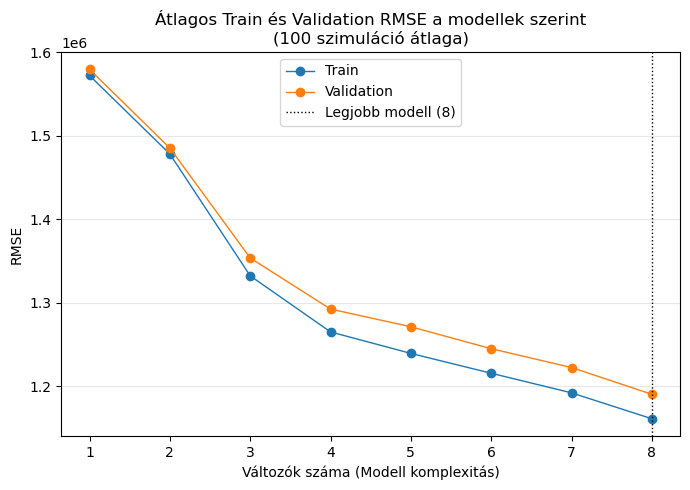

A legalacsonyabb validációs hiba átlaga (1190226.7252) a(z) 8. modellnél van.


In [19]:
# ---- Adatok előkészítése az ábrához ----

# 1. Kiszámoljuk az átlagos RMSE-t minden modellre (oszlopok mentén átlagolunk)
# A np.nanmean biztosítja, hogy ha van NaN érték, az ne rontsa el az átlagot
avg_rmse_tr = np.nanmean(rmse_tr_mat, axis=0)
avg_rmse_va = np.nanmean(rmse_va_mat, axis=0)

# A modellek komplexitása (változók száma 1-től 8-ig)
degrees = list(range(1, 9))

# 2. Létrehozzuk a 'summ_df' nevű DataFrame-et, pont ahogy a mintában volt
# Ez összefűzi a Train és Validation adatokat egy hosszú formátumú táblázatba
summ_df = pd.concat([
    pd.DataFrame({"degree": degrees, "set": "Train", "rmse": avg_rmse_tr}),
    pd.DataFrame({"degree": degrees, "set": "Validation", "rmse": avg_rmse_va})
], ignore_index=True)

# 3. Megkeressük a legjobb modellt (ahol a Validation RMSE a legalacsonyabb)
best_model_idx = np.argmin(avg_rmse_va)
best_deg = degrees[best_model_idx]

# ---- Ábrázolás (Gy08b stílusban) ----
fig, ax = plt.subplots(figsize=(7,5))

# Vonalak kirajzolása
for label, dfp in summ_df.groupby("set"):
    ax.plot(dfp["degree"], dfp["rmse"], marker="o", label=label, linewidth=1.0)

# Függőleges vonal a legjobb modellhez (szaggatott vonal)
ax.axvline(best_deg, linestyle=":", linewidth=1.0, color='black', label=f'Legjobb modell ({best_deg})')

# Tengelyek formázása
ax.set_xticks(degrees)
ax.set_title("Átlagos Train és Validation RMSE a modellek szerint\n(100 szimuláció átlaga)")
ax.set_xlabel("Változók száma (Modell komplexitás)")
ax.set_ylabel("RMSE")

# Jelmagyarázat és rács
ax.legend(loc="upper center") # Vagy "best", ha takarná az ábrát
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Kiíratjuk a legjobb modellt is számszerűen
print(f"A legalacsonyabb validációs hiba átlaga ({np.min(avg_rmse_va):.4f}) a(z) {best_deg}. modellnél van.")

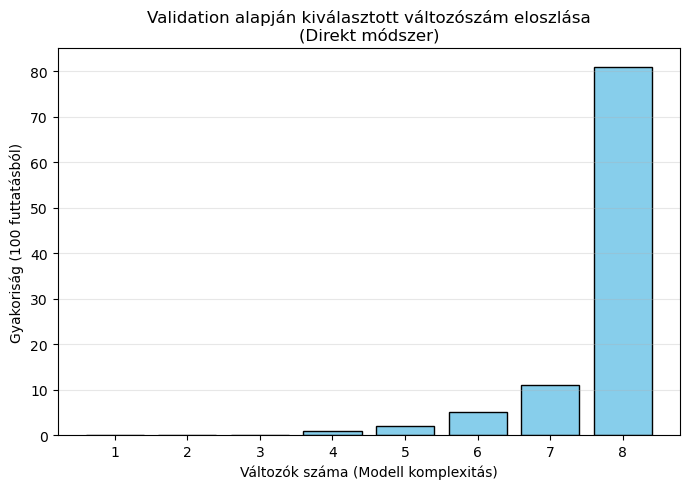

   Degree  Count
0       1      0
1       2      0
2       3      0
3       4      1
4       5      2
5       6      5
6       7     11
7       8     81


In [20]:
# ---- Adatok előkészítése az ábrához ----

# 1. Kivesszük a 'Direkt' módszer által választott modellek indexeit (1-től 8-ig)
# A te kódodban ez a picks['Direkt'] tömbben van
deg_chosen = picks['Direkt']

# 2. A lehetséges változószámok (1-től 8-ig)
degrees = list(range(1, 9))

# 3. Létrehozzuk a gyakorisági táblázatot (chosen_tab)
# Megszámoljuk, hányszor választotta a validáció az egyes modelleket
chosen_tab = (pd.Series(deg_chosen, name="Degree")
              .value_counts(sort=False)
              .reindex(degrees, fill_value=0) # Hogy a 0-szor választottak is látszódjanak
              .reset_index())
chosen_tab.columns = ["Degree", "Count"]

# ---- Ábrázolás (a kért kóddal) ----
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(chosen_tab["Degree"], chosen_tab["Count"], color='skyblue', edgecolor='black') # Kicsit csinosítva
ax.set_xticks(degrees)
ax.set_title("Validation alapján kiválasztott változószám eloszlása\n(Direkt módszer)")
ax.set_xlabel("Változók száma (Modell komplexitás)")
ax.set_ylabel("Gyakoriság (100 futtatásból)")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Kiíratjuk az adatokat is
print(chosen_tab)

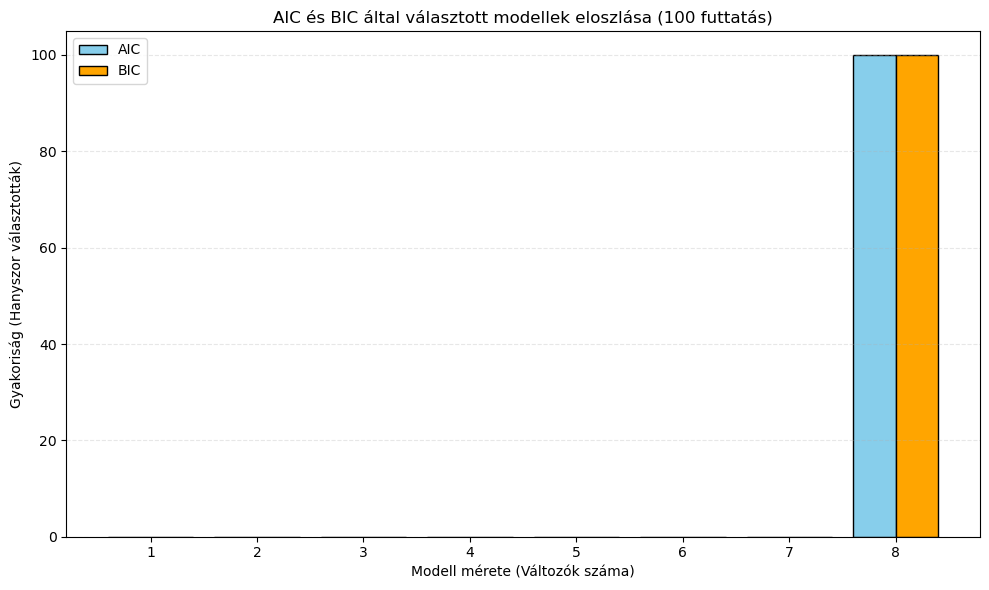

--- Kiválasztási Gyakoriságok ---
   model_id  AIC  BIC
0         1    0    0
1         2    0    0
2         3    0    0
3         4    0    0
4         5    0    0
5         6    0    0
6         7    0    0
7         8  100  100


In [21]:
# ---- Adatok előkészítése az AIC/BIC ábrához ----

# 1. Létrehozzuk a model_lookup segédtáblát (1-től 8-ig, mert 8 modellünk van)
n_models = 8 
model_ids = np.arange(1, n_models + 1)

model_lookup = pd.DataFrame({
    "model_id": model_ids
})

# 2. Összeszámoljuk, hányszor választották az egyes modelleket
# A picks szótárból vesszük ki az adatokat, ami a javított szimulációban keletkezett
aic_data = picks['AIC']
bic_data = picks['BIC']

# A reindex(model_ids, fill_value=0) biztosítja, hogy a 0-szor választott modellek is szerepeljenek 0-val
aic_counts = (pd.Series(aic_data)
              .value_counts(sort=False)
              .reindex(model_ids, fill_value=0))

bic_counts = (pd.Series(bic_data)
              .value_counts(sort=False)
              .reindex(model_ids, fill_value=0))

# 3. Létrehozzuk a pick_df DataFrame-et, amit a rajzoló kód vár
pick_df = pd.DataFrame({
    "model_id": model_ids,
    "AIC": aic_counts.values,
    "BIC": bic_counts.values
})

# ---- Ábrázolás ----
fig, ax = plt.subplots(figsize=(10, 6)) 
width = 0.4
x = np.arange(len(model_lookup))

# Oszlopok kirajzolása
ax.bar(x - width/2, pick_df["AIC"].values, width=width, label="AIC", color='skyblue', edgecolor='black')
ax.bar(x + width/2, pick_df["BIC"].values, width=width, label="BIC", color='orange', edgecolor='black')

# Tengelyek és címkék beállítása
ax.set_xticks(x)
ax.set_xticklabels(model_lookup["model_id"].values)
ax.set_title("AIC és BIC által választott modellek eloszlása (100 futtatás)", fontsize=12)
ax.set_xlabel("Modell mérete (Változók száma)", fontsize=10)
ax.set_ylabel("Gyakoriság (Hanyszor választották)", fontsize=10)

# Jelmagyarázat és rács
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, axis="y", alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Kiíratjuk az adatokat táblázatosan is ellenőrzésképp
print("--- Kiválasztási Gyakoriságok ---")
print(pick_df)

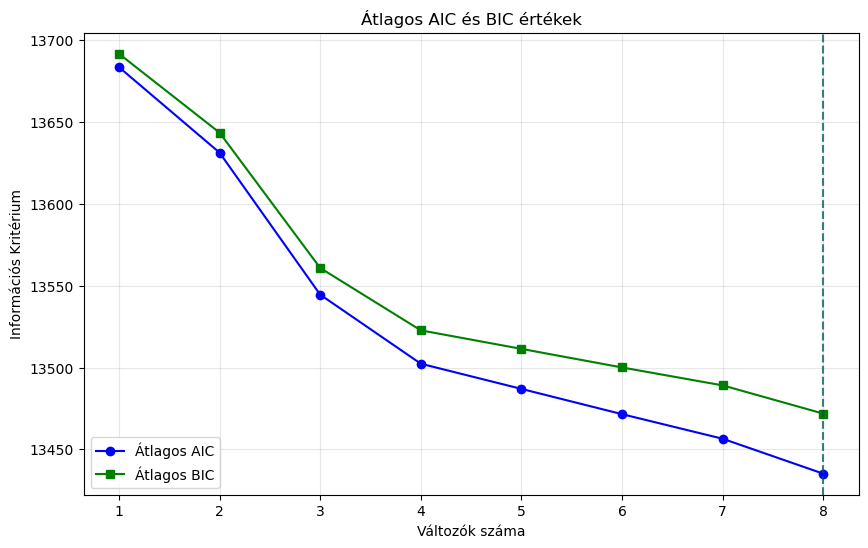

In [22]:
# Feltételezve, hogy az AIC_mat és BIC_mat már ki van számolva:
avg_aic = np.mean(AIC_mat, axis=0)
avg_bic = np.mean(BIC_mat, axis=0)
model_sizes = np.arange(1, len(avg_aic) + 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model_sizes, avg_aic, marker='o', label='Átlagos AIC', color='blue')
ax.plot(model_sizes, avg_bic, marker='s', label='Átlagos BIC', color='green')

# Minimumok jelölése
ax.axvline(model_sizes[np.argmin(avg_aic)], color='blue', linestyle='--', alpha=0.5)
ax.axvline(model_sizes[np.argmin(avg_bic)], color='green', linestyle='--', alpha=0.5)

ax.set_xlabel('Változók száma')
ax.set_ylabel('Információs Kritérium')
ax.set_title('Átlagos AIC és BIC értékek')
ax.set_xticks(model_sizes)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

Adatok előkészítése a LASSO ábrához...


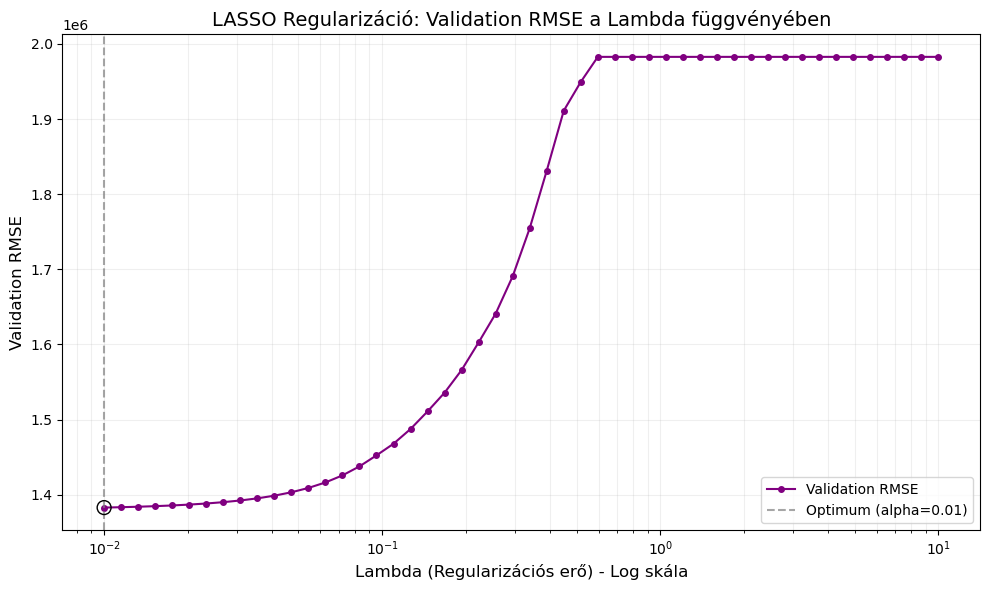

In [24]:
# ---- 1. ADATOK ELŐKÉSZÍTÉSE (Egy demonstrációs vágáshoz) ----
# Hogy biztosan legyenek definiált változók a plotoláshoz
print("Adatok előkészítése a LASSO ábrához...")

# Véletlenszerű vágás (64% Train, 16% Validation)
rng = np.random.default_rng(42)
indices = np.arange(len(df))
rng.shuffle(indices)

n_train = int(len(df) * 0.64)
n_valid = int(len(df) * 0.16)

train_idx = indices[:n_train]
valid_idx = indices[n_train:n_train+n_valid]

trn = df.iloc[train_idx].reset_index(drop=True)
val = df.iloc[valid_idx].reset_index(drop=True) # Itt definiáljuk a 'val'-t

# Változók kiválasztása
cols = [f"x{i}" for i in range(1, 9)]
X_train = trn[cols].values
y_train = trn['y'].values
X_valid = val[cols].values

# Skálázás (X és Y is, mert a kódodban scaler_y.inverse_transform van)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_sc = scaler_X.fit_transform(X_train)
y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
X_valid_sc = scaler_X.transform(X_valid)

# ---- 2. LAMBDA KERESÉS ÉS PLOTOLÁS (A te kódod) ----
alphas_for_plot = np.logspace(np.log10(0.01), np.log10(10), 50)
lasso_rmses = []

for alpha in alphas_for_plot:
    # Modell illesztése a skálázott adatokon
    l = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    l.fit(X_train_sc, y_train_sc)
    
    # Predikció
    pred_sc = l.predict(X_valid_sc)
    
    # Visszaskálázás az eredeti árkategóriába
    pred = scaler_y.inverse_transform(pred_sc.reshape(-1,1)).flatten()
    
    # Hiba számítása (eredeti y-on)
    lasso_rmses.append(rmse(val['y'], pred))

# Optimum megkeresése a plotoláshoz
min_rmse_lasso = min(lasso_rmses)
best_alpha_plot = alphas_for_plot[np.argmin(lasso_rmses)]

# ---- 3. ÁBRÁZOLÁS ----
plt.figure(figsize=(10, 6))
plt.plot(alphas_for_plot, lasso_rmses, marker='o', color='purple', markersize=4, label='Validation RMSE')

# Optimum jelölése
plt.axvline(best_alpha_plot, color='gray', linestyle='--', alpha=0.7, label=f'Optimum (alpha={best_alpha_plot:.2f})')
plt.scatter([best_alpha_plot], [min_rmse_lasso], s=100, facecolors='none', edgecolors='black', zorder=5)

# Formázás
plt.xscale('log')  # Logaritmikus skála
plt.title('LASSO Regularizáció: Validation RMSE a Lambda függvényében', fontsize=14)
plt.xlabel('Lambda (Regularizációs erő) - Log skála', fontsize=12)
plt.ylabel('Validation RMSE', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

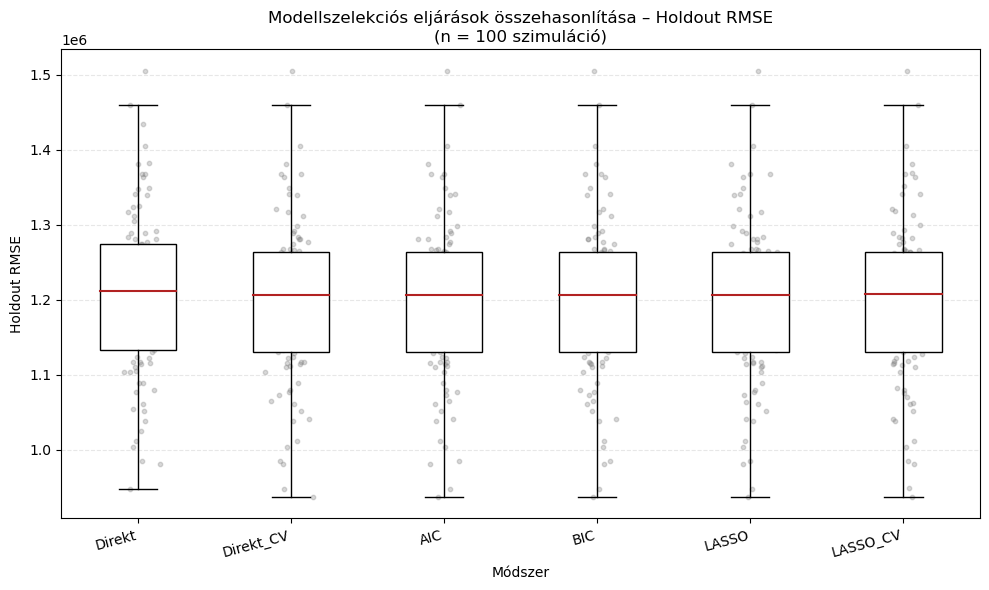


--- Medián Holdout RMSE értékek ---
Direkt    : 1211227
Direkt_CV : 1206923
AIC       : 1206923
BIC       : 1206923
LASSO     : 1206940
LASSO_CV  : 1207115


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---- 1. ADATOK ÖSSZEGYŰJTÉSE ----
# A szimuláció eredményeit egy DataFrame-be rendezzük
# Figyelem: A 'rmse_LASSO' tömbben van a CV-s Lasso eredménye a kódod alapján
res_df = pd.DataFrame(holdout_rmses)

# Biztonsági lépés: Ha a 'LASSO_CV' oszlop üres lenne a dict-ben,
# felülírjuk a 'rmse_LASSO' tömb értékeivel, ami a GridSearchCV eredménye
if 'rmse_LASSO' in locals():
    res_df['LASSO_CV'] = rmse_LASSO

# Oszlopok sorrendjének beállítása a logikus csoportosításért
# (Direkt módszerek, IC alapúak, Regularizáció)
ordered_cols = ['Direkt', 'Direkt_CV', 'AIC', 'BIC', 'LASSO', 'LASSO_CV']
# Csak azokat hagyjuk meg, amik tényleg léteznek
existing_cols = [c for c in ordered_cols if c in res_df.columns]
res_df = res_df[existing_cols]

# ---- 2. ÁBRÁZOLÁS (A kért stílusban) ----
fig, ax = plt.subplots(figsize=(10, 6))

labels = list(res_df.columns)
# Kiszűrjük a NaN értékeket (ha esetleg volt hibás futás)
data = [res_df[c].dropna().values for c in labels]

# Boxplot (kivülállók nélkül, hogy a skála ne torzuljon)
ax.boxplot(data, showfliers=False, patch_artist=True,
           boxprops=dict(facecolor='white', color='black'),
           medianprops=dict(color='firebrick', linewidth=1.5))

# Jitter plot (szórt pontok hozzáadása)
# Ez a "trükk": minden kategóriához (1, 2, 3...) adunk egy kis véletlen x-eltolást
for i, y in enumerate(data, start=1):
    # i a kategória indexe (x tengely), a 0.06 a szórás szélessége
    x = np.random.normal(i, 0.06, size=len(y))
    ax.scatter(x, y, s=10, alpha=0.3, color='grey', zorder=1)

# Formázás
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=15, ha="right", fontsize=10)
ax.set_title(f"Modellszelekciós eljárások összehasonlítása – Holdout RMSE\n(n = {len(res_df)} szimuláció)", fontsize=12)
ax.set_ylabel("Holdout RMSE", fontsize=10)
ax.set_xlabel("Módszer", fontsize=10)

# Rács a könnyebb olvashatóságért
ax.grid(True, axis="y", alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# ---- 3. SZÖVEGES ÖSSZEGZÉS (Mediánok) ----
print("\n--- Medián Holdout RMSE értékek ---")
for col in existing_cols:
    median_val = np.nanmedian(res_df[col])
    print(f"{col:10}: {median_val:.0f}")

In [28]:
# ---- Adatok előkészítése: Train és Validation RMSE átlagok modellenként ----

# 1. Átlagoljuk a 100 futtatás eredményét oszloponként (modellenként)
# A rmse_tr_mat és rmse_va_mat (100 sor, 8 oszlop) mátrixokból indulunk ki
avg_train_rmse = np.nanmean(rmse_tr_mat, axis=0)
avg_valid_rmse = np.nanmean(rmse_va_mat, axis=0)

# 2. Összeállítjuk a táblázatot
model_data = []
for i in range(8):
    model_data.append({
        'Modell (Változók száma)': i + 1,
        'Átlagos Train RMSE': f"{avg_train_rmse[i]:,.0f}",
        'Átlagos Validation RMSE': f"{avg_valid_rmse[i]:,.0f}"
    })

df_models = pd.DataFrame(model_data)

# 3. Megjelenítés
print("\n--- 2. Táblázat: Átlagos Train és Validation Hiba Modellenként ---")
display(df_models)

# Latex kód (opcionális)
# print(df_models.to_latex(index=False))


--- 2. Táblázat: Átlagos Train és Validation Hiba Modellenként ---


,Modell (Változók száma),Átlagos Train RMSE,Átlagos Validation RMSE
0,1,"1,572,000","1,579,287"
1,2,"1,477,964","1,485,108"
2,3,"1,332,069","1,353,473"
3,4,"1,264,910","1,292,263"
4,5,"1,239,170","1,271,089"
5,6,"1,215,423","1,244,793"
6,7,"1,191,928","1,222,268"
7,8,"1,160,920","1,190,227"


In [26]:
data = []
for m in methods:
    # RMSE statisztikák
    rmse_vals = holdout_rmses[m]
    rmse_mean = np.nanmean(rmse_vals)
    rmse_std = np.nanstd(rmse_vals)
    
    # MAE statisztikák
    mae_vals = holdout_maes[m]
    mae_mean = np.nanmean(mae_vals)
    mae_std = np.nanstd(mae_vals)
    
    # Kiválasztott változók átlagos száma
    avg_vars = np.mean(picks[m])
    
    data.append({
        'Módszer': m,
        'Holdout RMSE (Mean ± SD)': f"{rmse_mean:,.0f} ± {rmse_std:,.0f}",
        'Holdout MAE (Mean ± SD)': f"{mae_mean:,.0f} ± {mae_std:,.0f}",
        'Átlagos Változószám': f"{avg_vars:.1f}"
    })

summary_table = pd.DataFrame(data)
print("\n--- 1. Összefoglaló Táblázat: Holdout Teljesítmény ---")
display(summary_table)


--- 1. Összefoglaló Táblázat: Holdout Teljesítmény ---


,Módszer,Holdout RMSE (Mean ± SD),Holdout MAE (Mean ± SD),Átlagos Változószám
0,Direkt,"1,207,093 ± 108,788","877,684 ± 68,135",7.7
1,Direkt_CV,"1,197,985 ± 105,561","871,396 ± 65,875",8.0
2,AIC,"1,197,985 ± 105,561","871,396 ± 65,875",8.0
3,BIC,"1,197,985 ± 105,561","871,396 ± 65,875",8.0
4,LASSO,"1,197,984 ± 105,564","871,392 ± 65,876",8.0
5,LASSO_CV,"1,198,007 ± 105,863","871,238 ± 65,916",8.0
